.



# I. Importing the required libraries

In [1]:
!python --version 
%pip -V

Python 3.10.11
pip 23.0.1 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%pip install --upgrade pip
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install librosa
%pip install resampy
%pip install seaborn
%pip install scipy
%pip install tensorflow
%pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Lookin

In [4]:

## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.utils import pad_sequences, to_categorical, np_utils
from keras.preprocessing.text import Tokenizer


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

# II. Reading the data

In [5]:
# Data Directory

dir_list = os.listdir('/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [6]:
# Create DataFrame for Data intel

data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = '/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [7]:
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,1,0,1
1,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,0,1,1
2,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,1,1,1
3,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,0,1,2
4,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,0,0,1


#  Plotting the audio file's waveform and its spectrogram

In [8]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_18/03-01-01-01-01-02-18.wav


(22050,
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.8075044e-15,
        2.6088815e-14, 0.0000000e+00], dtype=float32))

In [9]:
len(samples), sample_rate

(77989, 22050)

In [10]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [11]:
sample_rate/ len(samples)

0.28273218017925605

Text(0.5, 0, 'Seconds')

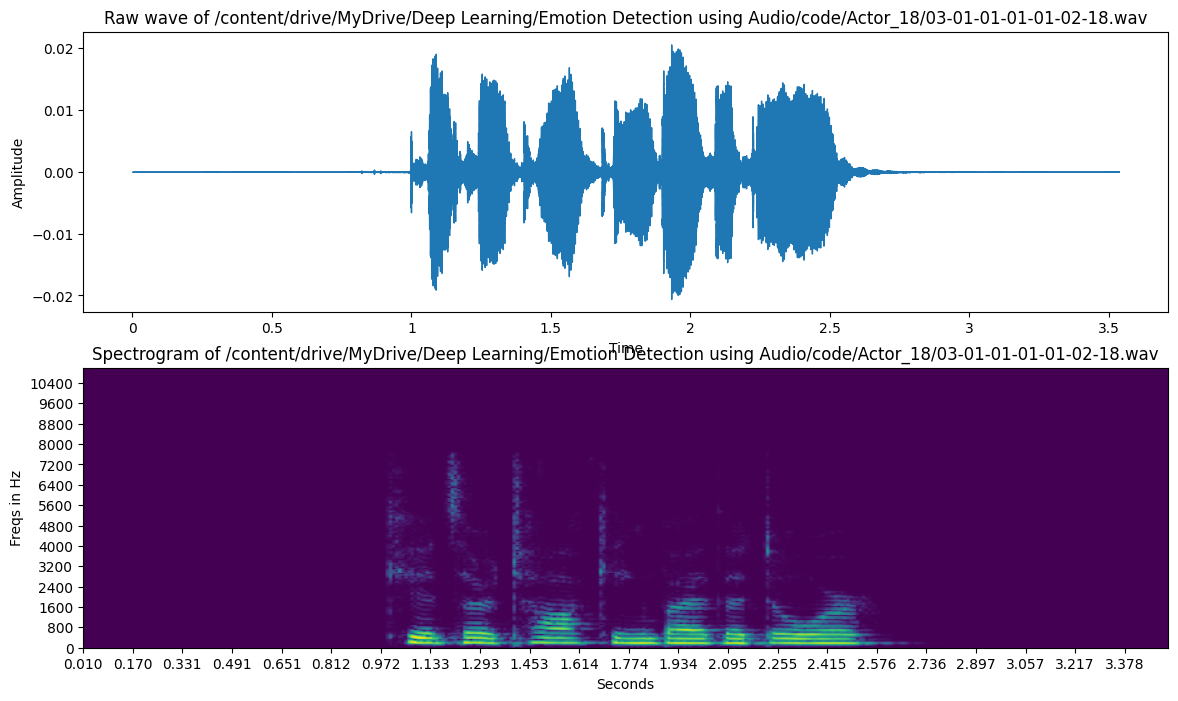

In [12]:
# Plotting Wave Form and Spectrogram

freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveshow(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [13]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [14]:
# Trim the silence voice

aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-4.1166031e-06,  5.1101779e-07,  2.0558143e-06, ...,
         4.0682771e-05,  1.8916358e-05,  5.5585815e-08], dtype=float32),
 array([20992, 58880]))

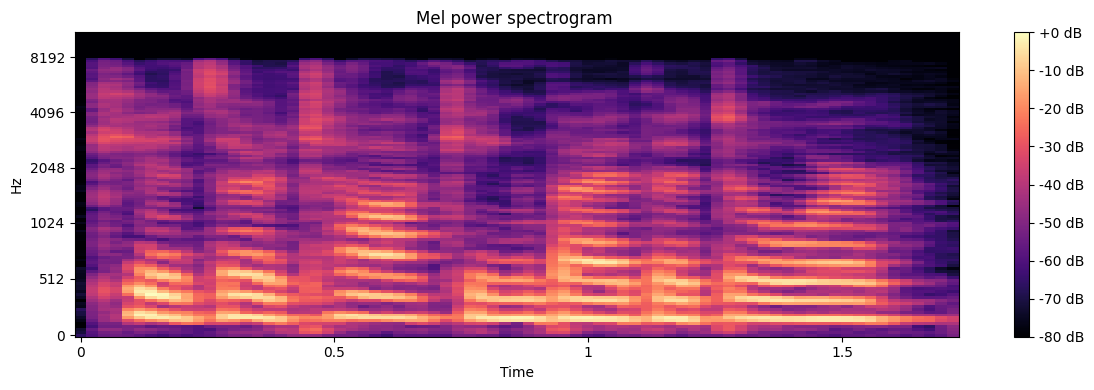

In [15]:
# Plotting Mel Power Spectrogram

S = librosa.feature.melspectrogram(y=aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

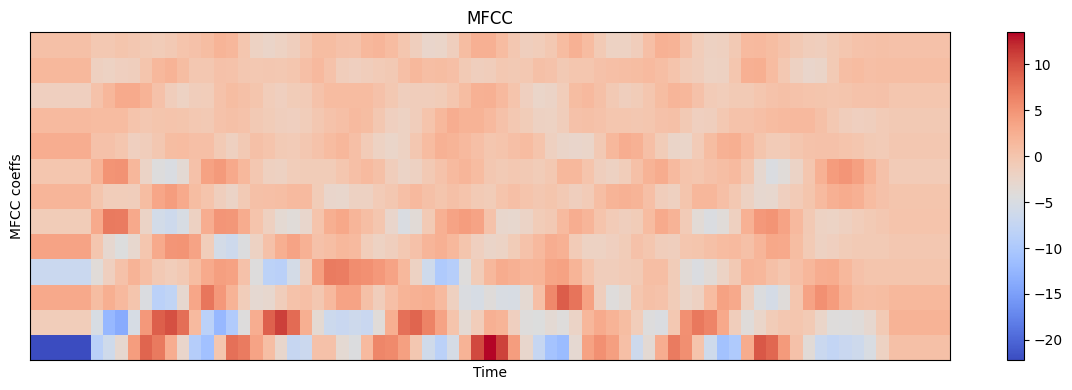

In [16]:
# Plotting MFCC

mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [17]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [18]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [19]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# IV. Defining the truth label

In [20]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1440

In [21]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [22]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [23]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [24]:
# Selecting the label set we want by commenting the unwanteds.

data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,1,0,1,male_none
1,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,0,1,1,male_none
2,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,1,1,1,male_none
3,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,0,1,2,male_positive
4,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,0,0,1,male_none


In [25]:
print (data_df.label.value_counts().keys())

Index(['male_negative', 'female_negative', 'male_none', 'female_none',
       'male_positive', 'female_positive'],
      dtype='object')


In [26]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

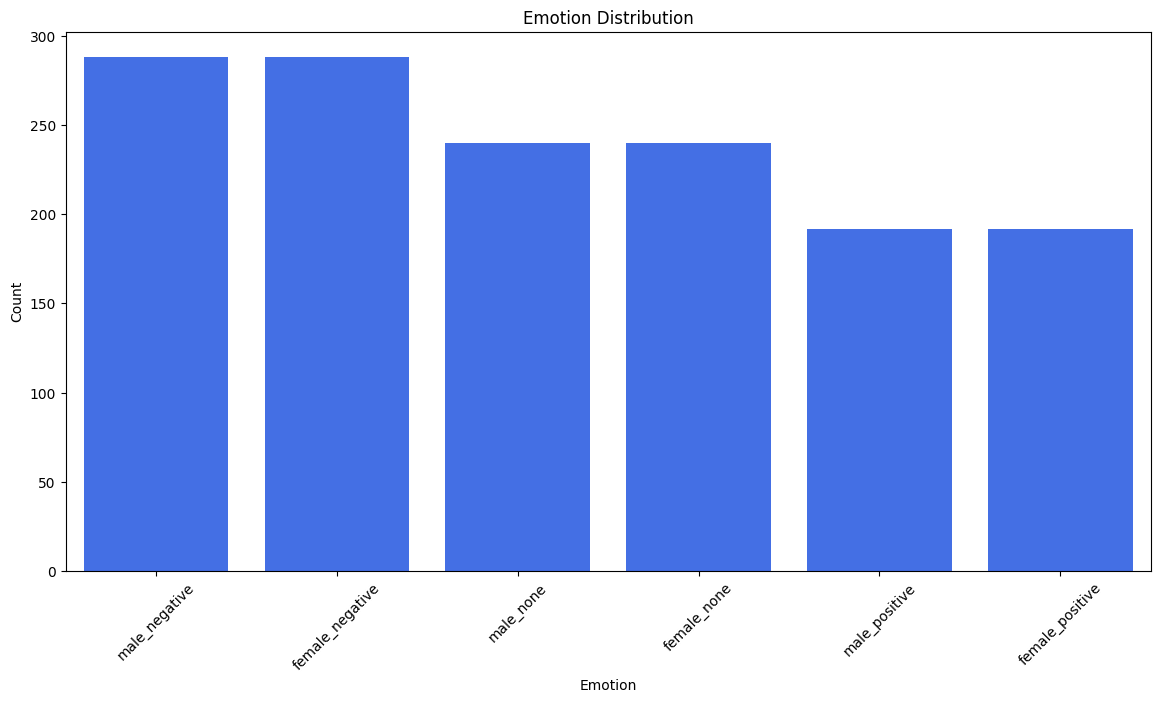

In [27]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# V. Data Splitting

In [28]:
# Female Data Set

## Uncomment all below to use Female set 

# data2_df = data_df.copy()
# data2_df = data2_df[data2_df.label != "male_none"]
# data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
# data2_df = data2_df[data2_df.label != "male_fearful"]
# data2_df = data2_df[data2_df.label != "male_calm"]
# data2_df = data2_df[data2_df.label != "male_positive"]
# data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()

In [29]:
# Male Data Set

## Uncomment all below to use Male set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

400


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,0,1,2,male_positive
1,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,0,0,2,male_positive
2,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,1,0,2,male_positive
3,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,1,1,3,male_positive
4,/content/drive/MyDrive/Deep Learning/Emotion D...,1,1,male,0,1,1,6,male_negative


In [30]:
print (len(data3_df))
data3_df.head()

80


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/drive/MyDrive/Deep Learning/Emotion D...,1,21,male,0,0,0,2,male_positive
1,/content/drive/MyDrive/Deep Learning/Emotion D...,1,21,male,0,0,1,2,male_positive
2,/content/drive/MyDrive/Deep Learning/Emotion D...,1,21,male,0,1,0,2,male_positive
3,/content/drive/MyDrive/Deep Learning/Emotion D...,1,21,male,1,0,1,2,male_positive
4,/content/drive/MyDrive/Deep Learning/Emotion D...,1,21,male,1,0,0,2,male_positive


# VI. Getting the features of audio files using librosa

In [31]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    print("\n" + data2_df.path[i])
    X, sample_rate = librosa.core.load(path=data2_df.path[i], res_type='kaiser_fast', duration=input_duration, sr=22050*2, offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

  0%|          | 0/400 [00:00<?, ?it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-02-01-01-02-01.wav


  0%|          | 1/400 [00:00<04:40,  1.42it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-02-01-01-01-01.wav


  0%|          | 2/400 [00:01<03:22,  1.96it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-02-01-02-01-01.wav


  1%|          | 3/400 [00:01<02:35,  2.55it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-03-01-02-02-01.wav


  1%|          | 4/400 [00:01<02:21,  2.80it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-06-01-02-02-01.wav


  1%|▏         | 5/400 [00:01<02:06,  3.13it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-03-02-01-01-01.wav


  2%|▏         | 6/400 [00:02<01:58,  3.32it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-05-02-02-02-01.wav


  2%|▏         | 7/400 [00:02<01:53,  3.46it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-03-02-01-02-01.wav


  2%|▏         | 8/400 [00:02<01:46,  3.67it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-06-01-02-01-01.wav


  2%|▏         | 9/400 [00:02<01:43,  3.78it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-02-02-01-02-01.wav


  2%|▎         | 10/400 [00:03<01:39,  3.91it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-04-01-01-01-01.wav


  3%|▎         | 11/400 [00:03<01:45,  3.70it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-05-01-01-01-01.wav


  3%|▎         | 12/400 [00:03<01:43,  3.75it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-06-02-01-01-01.wav


  3%|▎         | 13/400 [00:03<01:43,  3.74it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-03-01-01-02-01.wav


  4%|▎         | 14/400 [00:04<01:38,  3.92it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-03-01-02-01-01.wav


  4%|▍         | 15/400 [00:04<01:34,  4.06it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-02-02-01-01-01.wav


  4%|▍         | 16/400 [00:04<01:32,  4.15it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-06-01-01-01-01.wav


  4%|▍         | 18/400 [00:05<01:25,  4.48it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-03-01-01-01-01.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-05-02-01-02-01.wav


  5%|▍         | 19/400 [00:05<01:31,  4.18it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-04-01-02-02-01.wav


  5%|▌         | 20/400 [00:05<01:30,  4.19it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-04-02-02-01-01.wav


  5%|▌         | 21/400 [00:05<01:31,  4.16it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-05-01-02-02-01.wav


  6%|▌         | 22/400 [00:06<01:37,  3.88it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-04-02-01-01-01.wav


  6%|▌         | 23/400 [00:06<01:33,  4.02it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-06-02-01-02-01.wav


  6%|▌         | 24/400 [00:06<01:38,  3.82it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-02-02-02-02-01.wav


  6%|▋         | 25/400 [00:06<01:37,  3.85it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-06-01-01-02-01.wav


  6%|▋         | 26/400 [00:07<01:34,  3.94it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-05-01-01-02-01.wav


  7%|▋         | 27/400 [00:07<01:37,  3.84it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-06-02-02-01-01.wav


  7%|▋         | 28/400 [00:07<01:35,  3.88it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-03-02-02-02-01.wav


  7%|▋         | 29/400 [00:07<01:33,  3.97it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-05-02-02-01-01.wav


  8%|▊         | 30/400 [00:08<01:34,  3.89it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-03-02-02-01-01.wav


  8%|▊         | 31/400 [00:08<01:38,  3.73it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-02-01-02-02-01.wav


  8%|▊         | 32/400 [00:08<01:37,  3.76it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-05-02-01-01-01.wav


  8%|▊         | 33/400 [00:08<01:37,  3.77it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-04-02-02-02-01.wav


  8%|▊         | 34/400 [00:09<01:35,  3.84it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-04-02-01-02-01.wav


  9%|▉         | 35/400 [00:09<01:34,  3.86it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-06-02-02-02-01.wav


  9%|▉         | 36/400 [00:09<01:33,  3.88it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-02-02-02-01-01.wav


  9%|▉         | 37/400 [00:09<01:30,  4.02it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-05-01-02-01-01.wav


 10%|▉         | 38/400 [00:10<01:29,  4.06it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-04-01-01-02-01.wav


 10%|▉         | 39/400 [00:10<01:29,  4.05it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_01/03-01-04-01-02-01-01.wav


 10%|█         | 40/400 [00:10<01:26,  4.15it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-04-02-02-01-03.wav


 10%|█         | 41/400 [00:10<01:30,  3.98it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-04-01-02-01-03.wav


 10%|█         | 42/400 [00:11<01:30,  3.96it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-04-02-01-01-03.wav


 11%|█         | 43/400 [00:11<01:27,  4.08it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-05-01-02-01-03.wav


 11%|█         | 44/400 [00:11<01:23,  4.27it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-06-02-02-02-03.wav


 12%|█▏        | 46/400 [00:12<01:17,  4.55it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-03-02-02-01-03.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-06-02-01-01-03.wav


 12%|█▏        | 47/400 [00:12<01:20,  4.37it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-04-01-01-02-03.wav


 12%|█▏        | 48/400 [00:12<01:19,  4.44it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-03-02-01-02-03.wav


 12%|█▏        | 49/400 [00:12<01:26,  4.06it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-06-02-01-02-03.wav


 12%|█▎        | 50/400 [00:13<01:26,  4.05it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-03-02-01-01-03.wav


 13%|█▎        | 51/400 [00:13<01:29,  3.90it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-04-02-02-02-03.wav


 13%|█▎        | 52/400 [00:13<01:28,  3.93it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-02-02-02-02-03.wav


 13%|█▎        | 53/400 [00:13<01:29,  3.88it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-06-01-02-02-03.wav


 14%|█▎        | 54/400 [00:14<01:31,  3.80it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-05-01-02-02-03.wav


 14%|█▍        | 55/400 [00:14<01:30,  3.80it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-04-01-02-02-03.wav


 14%|█▍        | 56/400 [00:14<01:28,  3.88it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-04-01-01-01-03.wav


 14%|█▍        | 57/400 [00:14<01:28,  3.89it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-02-01-02-01-03.wav


 15%|█▍        | 59/400 [00:15<01:23,  4.06it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-06-01-02-01-03.wav


 15%|█▌        | 60/400 [00:15<01:21,  4.19it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-05-01-01-02-03.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-03-01-01-02-03.wav


 15%|█▌        | 61/400 [00:15<01:19,  4.27it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-05-02-01-01-03.wav


 16%|█▌        | 62/400 [00:16<01:21,  4.16it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-02-01-01-01-03.wav


 16%|█▌        | 63/400 [00:16<01:25,  3.94it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-06-01-01-01-03.wav


 16%|█▌        | 64/400 [00:16<01:26,  3.88it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-02-01-01-02-03.wav


 16%|█▋        | 65/400 [00:16<01:26,  3.86it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-04-02-01-02-03.wav


 16%|█▋        | 66/400 [00:17<01:40,  3.33it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-02-02-01-02-03.wav


 17%|█▋        | 67/400 [00:17<01:38,  3.38it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-05-02-02-01-03.wav


 17%|█▋        | 68/400 [00:17<01:33,  3.54it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-05-02-01-02-03.wav


 17%|█▋        | 69/400 [00:18<01:35,  3.48it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-02-02-01-01-03.wav


 18%|█▊        | 70/400 [00:18<01:33,  3.51it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-03-02-02-02-03.wav


 18%|█▊        | 71/400 [00:18<01:53,  2.89it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-03-01-01-01-03.wav


 18%|█▊        | 72/400 [00:19<01:46,  3.07it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-02-01-02-02-03.wav


 18%|█▊        | 73/400 [00:19<01:43,  3.17it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-03-01-02-02-03.wav


 18%|█▊        | 74/400 [00:19<01:34,  3.47it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-06-02-02-01-03.wav


 19%|█▉        | 75/400 [00:20<01:34,  3.44it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-03-01-02-01-03.wav


 19%|█▉        | 76/400 [00:20<01:30,  3.56it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-05-02-02-02-03.wav


 19%|█▉        | 77/400 [00:20<01:24,  3.82it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-05-01-01-01-03.wav


 20%|█▉        | 78/400 [00:20<01:20,  4.02it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-06-01-01-02-03.wav


 20%|█▉        | 79/400 [00:20<01:17,  4.14it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_03/03-01-02-02-02-01-03.wav


 20%|██        | 80/400 [00:21<01:20,  3.99it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-02-01-01-01-05.wav


 20%|██        | 81/400 [00:21<01:25,  3.72it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-02-01-01-02-05.wav


 20%|██        | 82/400 [00:21<01:25,  3.70it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-02-01-02-01-05.wav


 21%|██        | 83/400 [00:22<01:24,  3.77it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-02-01-02-02-05.wav


 21%|██        | 84/400 [00:22<01:24,  3.73it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-02-02-01-01-05.wav


 21%|██▏       | 85/400 [00:22<01:28,  3.55it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-02-02-02-01-05.wav


 22%|██▏       | 86/400 [00:22<01:26,  3.65it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-02-02-01-02-05.wav


 22%|██▏       | 87/400 [00:23<01:24,  3.71it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-02-02-02-02-05.wav


 22%|██▏       | 88/400 [00:23<01:23,  3.73it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-03-01-01-02-05.wav


 22%|██▏       | 89/400 [00:23<01:19,  3.91it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-03-01-01-01-05.wav


 22%|██▎       | 90/400 [00:23<01:22,  3.74it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-03-01-02-01-05.wav


 23%|██▎       | 91/400 [00:24<01:22,  3.75it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-03-01-02-02-05.wav


 23%|██▎       | 92/400 [00:24<01:18,  3.91it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-03-02-01-01-05.wav


 23%|██▎       | 93/400 [00:24<01:22,  3.72it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-03-02-01-02-05.wav


 24%|██▎       | 94/400 [00:24<01:21,  3.74it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-03-02-02-01-05.wav


 24%|██▍       | 95/400 [00:25<01:24,  3.62it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-04-01-01-01-05.wav


 24%|██▍       | 96/400 [00:25<01:23,  3.64it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-04-01-01-02-05.wav


 24%|██▍       | 97/400 [00:25<01:21,  3.73it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-03-02-02-02-05.wav


 24%|██▍       | 98/400 [00:26<01:16,  3.96it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-04-01-02-02-05.wav


 25%|██▍       | 99/400 [00:26<01:19,  3.77it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-04-01-02-01-05.wav


 25%|██▌       | 100/400 [00:26<01:17,  3.88it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-04-02-02-01-05.wav


 25%|██▌       | 101/400 [00:26<01:15,  3.97it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-04-02-01-01-05.wav


 26%|██▌       | 102/400 [00:27<01:13,  4.03it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-04-02-01-02-05.wav


 26%|██▌       | 104/400 [00:27<01:08,  4.35it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-04-02-02-02-05.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-05-01-01-01-05.wav


 26%|██▋       | 105/400 [00:27<01:08,  4.33it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-05-01-02-01-05.wav


 26%|██▋       | 106/400 [00:27<01:11,  4.12it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-05-01-01-02-05.wav


 27%|██▋       | 107/400 [00:28<01:08,  4.26it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-05-02-01-02-05.wav


 27%|██▋       | 108/400 [00:28<01:07,  4.34it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-05-01-02-02-05.wav


 27%|██▋       | 109/400 [00:28<01:09,  4.19it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-05-02-01-01-05.wav


 28%|██▊       | 110/400 [00:28<01:09,  4.18it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-05-02-02-01-05.wav


 28%|██▊       | 112/400 [00:29<01:06,  4.33it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-06-01-01-01-05.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-05-02-02-02-05.wav


 28%|██▊       | 113/400 [00:29<01:05,  4.36it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-06-01-01-02-05.wav


 28%|██▊       | 114/400 [00:29<01:07,  4.26it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-06-01-02-01-05.wav


 29%|██▉       | 115/400 [00:30<01:10,  4.06it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-06-01-02-02-05.wav


 29%|██▉       | 116/400 [00:30<01:14,  3.82it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-06-02-01-02-05.wav


 29%|██▉       | 117/400 [00:30<01:13,  3.84it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-06-02-02-01-05.wav


 30%|██▉       | 118/400 [00:30<01:12,  3.90it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-06-02-01-01-05.wav


 30%|██▉       | 119/400 [00:31<01:12,  3.90it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_05/03-01-06-02-02-02-05.wav


 30%|███       | 120/400 [00:31<01:11,  3.90it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-02-01-01-01-07.wav


 30%|███       | 121/400 [00:31<01:13,  3.78it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-02-01-01-02-07.wav


 30%|███       | 122/400 [00:32<01:17,  3.58it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-02-02-01-01-07.wav


 31%|███       | 123/400 [00:32<01:13,  3.77it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-02-01-02-01-07.wav


 31%|███       | 124/400 [00:32<01:13,  3.77it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-02-01-02-02-07.wav


 31%|███▏      | 125/400 [00:32<01:11,  3.87it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-02-02-02-01-07.wav


 32%|███▏      | 126/400 [00:33<01:10,  3.87it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-02-02-01-02-07.wav


 32%|███▏      | 127/400 [00:33<01:15,  3.62it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-02-02-02-02-07.wav


 32%|███▏      | 128/400 [00:33<01:19,  3.43it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-03-01-01-01-07.wav


 32%|███▏      | 129/400 [00:33<01:15,  3.59it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-03-01-01-02-07.wav


 32%|███▎      | 130/400 [00:34<01:17,  3.50it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-03-01-02-01-07.wav


 33%|███▎      | 131/400 [00:34<01:14,  3.59it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-03-01-02-02-07.wav


 33%|███▎      | 133/400 [00:34<01:06,  4.01it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-03-02-01-01-07.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-03-02-01-02-07.wav


 34%|███▎      | 134/400 [00:35<01:03,  4.18it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-03-02-02-02-07.wav


 34%|███▍      | 136/400 [00:35<01:00,  4.36it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-03-02-02-01-07.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-04-01-01-01-07.wav


 34%|███▍      | 137/400 [00:35<01:02,  4.22it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-04-01-01-02-07.wav


 34%|███▍      | 138/400 [00:36<01:20,  3.25it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-04-01-02-01-07.wav


 35%|███▍      | 139/400 [00:36<01:20,  3.24it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-04-01-02-02-07.wav


 35%|███▌      | 140/400 [00:36<01:15,  3.44it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-04-02-01-01-07.wav


 35%|███▌      | 141/400 [00:37<01:12,  3.57it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-04-02-01-02-07.wav


 36%|███▌      | 142/400 [00:37<01:09,  3.74it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-04-02-02-01-07.wav


 36%|███▌      | 143/400 [00:37<01:09,  3.70it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-04-02-02-02-07.wav


 36%|███▌      | 144/400 [00:37<01:07,  3.82it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-05-01-01-01-07.wav


 36%|███▋      | 145/400 [00:38<01:06,  3.85it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-05-01-01-02-07.wav


 36%|███▋      | 146/400 [00:38<01:04,  3.91it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-05-01-02-01-07.wav


 37%|███▋      | 147/400 [00:38<01:03,  3.98it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-05-01-02-02-07.wav


 37%|███▋      | 148/400 [00:38<01:03,  3.97it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-05-02-02-01-07.wav


 37%|███▋      | 149/400 [00:39<01:06,  3.78it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-05-02-02-02-07.wav


 38%|███▊      | 150/400 [00:39<01:05,  3.85it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-05-02-01-02-07.wav


 38%|███▊      | 151/400 [00:39<01:06,  3.75it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-05-02-01-01-07.wav


 38%|███▊      | 152/400 [00:39<01:03,  3.90it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-06-01-01-01-07.wav


 38%|███▊      | 153/400 [00:40<01:02,  3.92it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-06-01-02-02-07.wav


 38%|███▊      | 154/400 [00:40<01:02,  3.96it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-06-01-01-02-07.wav


 39%|███▉      | 155/400 [00:40<00:59,  4.14it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-06-02-01-01-07.wav


 39%|███▉      | 156/400 [00:40<00:58,  4.18it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-06-01-02-01-07.wav


 40%|███▉      | 158/400 [00:41<00:55,  4.36it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-06-02-01-02-07.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-06-02-02-01-07.wav


 40%|███▉      | 159/400 [00:41<00:55,  4.33it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_07/03-01-06-02-02-02-07.wav


 40%|████      | 160/400 [00:41<00:55,  4.34it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-02-01-01-02-09.wav


 40%|████      | 161/400 [00:42<00:54,  4.37it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-02-01-01-01-09.wav


 40%|████      | 162/400 [00:42<00:57,  4.17it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-02-01-02-01-09.wav


 41%|████      | 164/400 [00:42<00:54,  4.36it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-02-01-02-02-09.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-02-02-01-01-09.wav


 41%|████▏     | 165/400 [00:42<00:52,  4.49it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-02-02-01-02-09.wav


 42%|████▏     | 166/400 [00:43<00:54,  4.27it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-02-02-02-02-09.wav


 42%|████▏     | 167/400 [00:43<00:52,  4.43it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-03-01-01-01-09.wav


 42%|████▏     | 169/400 [00:43<00:50,  4.60it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-02-02-02-01-09.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-03-01-01-02-09.wav


 42%|████▎     | 170/400 [00:44<00:51,  4.43it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-03-01-02-02-09.wav


 43%|████▎     | 171/400 [00:44<00:50,  4.52it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-03-01-02-01-09.wav


 43%|████▎     | 172/400 [00:44<00:51,  4.43it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-03-02-01-01-09.wav


 43%|████▎     | 173/400 [00:44<00:51,  4.40it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-03-02-02-01-09.wav


 44%|████▎     | 174/400 [00:44<00:51,  4.39it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-03-02-01-02-09.wav


 44%|████▍     | 175/400 [00:45<00:50,  4.50it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-03-02-02-02-09.wav


 44%|████▍     | 176/400 [00:45<00:50,  4.46it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-04-01-01-01-09.wav


 44%|████▍     | 177/400 [00:45<00:53,  4.19it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-04-01-02-01-09.wav


 45%|████▍     | 179/400 [00:46<00:56,  3.93it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-04-01-01-02-09.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-04-01-02-02-09.wav


 45%|████▌     | 180/400 [00:46<00:56,  3.91it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-04-02-01-01-09.wav


 45%|████▌     | 181/400 [00:46<00:57,  3.84it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-04-02-01-02-09.wav


 46%|████▌     | 182/400 [00:47<00:55,  3.90it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-04-02-02-01-09.wav


 46%|████▌     | 183/400 [00:47<00:57,  3.79it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-04-02-02-02-09.wav


 46%|████▌     | 184/400 [00:47<00:59,  3.62it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-05-01-01-01-09.wav


 46%|████▋     | 185/400 [00:47<00:59,  3.64it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-05-01-01-02-09.wav


 46%|████▋     | 186/400 [00:48<00:54,  3.93it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-05-01-02-02-09.wav


 47%|████▋     | 187/400 [00:48<00:53,  4.01it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-05-01-02-01-09.wav


 47%|████▋     | 188/400 [00:48<00:50,  4.20it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-05-02-01-01-09.wav


 47%|████▋     | 189/400 [00:48<00:52,  4.02it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-05-02-02-01-09.wav


 48%|████▊     | 190/400 [00:49<00:50,  4.19it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-05-02-01-02-09.wav


 48%|████▊     | 191/400 [00:49<00:50,  4.17it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-05-02-02-02-09.wav


 48%|████▊     | 193/400 [00:49<00:46,  4.45it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-06-01-01-01-09.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-06-01-01-02-09.wav


 49%|████▉     | 195/400 [00:50<00:44,  4.59it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-06-01-02-01-09.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-06-01-02-02-09.wav


 49%|████▉     | 196/400 [00:50<00:43,  4.67it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-06-02-01-01-09.wav


 49%|████▉     | 197/400 [00:50<00:44,  4.53it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-06-02-01-02-09.wav


 50%|████▉     | 198/400 [00:50<00:51,  3.93it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-06-02-02-01-09.wav


 50%|████▉     | 199/400 [00:51<00:59,  3.38it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_09/03-01-06-02-02-02-09.wav


 50%|█████     | 200/400 [00:51<00:59,  3.35it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-02-01-02-01-11.wav


 50%|█████     | 201/400 [00:51<00:56,  3.51it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-02-01-02-02-11.wav


 50%|█████     | 202/400 [00:52<00:55,  3.59it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-02-01-01-01-11.wav


 51%|█████     | 203/400 [00:52<00:52,  3.75it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-02-01-01-02-11.wav


 51%|█████     | 204/400 [00:52<00:54,  3.61it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-02-02-01-01-11.wav


 51%|█████▏    | 205/400 [00:52<00:54,  3.61it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-02-02-01-02-11.wav


 52%|█████▏    | 206/400 [00:53<00:52,  3.72it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-02-02-02-01-11.wav


 52%|█████▏    | 207/400 [00:53<00:51,  3.72it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-03-01-01-01-11.wav


 52%|█████▏    | 208/400 [00:53<00:50,  3.81it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-02-02-02-02-11.wav


 52%|█████▏    | 209/400 [00:54<00:53,  3.58it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-03-01-02-01-11.wav


 52%|█████▎    | 210/400 [00:54<00:49,  3.82it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-03-02-01-01-11.wav


 53%|█████▎    | 211/400 [00:54<00:53,  3.56it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-03-01-02-02-11.wav


 53%|█████▎    | 212/400 [00:54<00:51,  3.67it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-03-02-02-01-11.wav


 53%|█████▎    | 213/400 [00:55<00:53,  3.48it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-03-01-01-02-11.wav


 54%|█████▎    | 214/400 [00:55<00:50,  3.72it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-03-02-01-02-11.wav


 54%|█████▍    | 215/400 [00:55<00:48,  3.78it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-03-02-02-02-11.wav


 54%|█████▍    | 216/400 [00:55<00:48,  3.79it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-04-01-01-01-11.wav


 55%|█████▍    | 218/400 [00:56<00:46,  3.91it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-04-01-01-02-11.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-04-01-02-02-11.wav


 55%|█████▍    | 219/400 [00:56<00:44,  4.05it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-04-01-02-01-11.wav


 55%|█████▌    | 220/400 [00:56<00:42,  4.20it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-04-02-01-01-11.wav


 55%|█████▌    | 221/400 [00:57<00:42,  4.21it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-04-02-01-02-11.wav


 56%|█████▌    | 222/400 [00:57<00:43,  4.13it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-05-01-01-01-11.wav


 56%|█████▌    | 224/400 [00:57<00:39,  4.49it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-04-02-02-01-11.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-04-02-02-02-11.wav


 56%|█████▋    | 225/400 [00:57<00:37,  4.61it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-05-01-01-02-11.wav


 56%|█████▋    | 226/400 [00:58<00:39,  4.37it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-05-01-02-01-11.wav


 57%|█████▋    | 227/400 [00:58<00:43,  4.00it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-05-02-01-02-11.wav


 57%|█████▋    | 228/400 [00:58<00:41,  4.18it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-05-02-01-01-11.wav


 57%|█████▋    | 229/400 [00:58<00:39,  4.30it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-05-02-02-02-11.wav


 57%|█████▊    | 230/400 [00:59<00:42,  4.02it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-05-02-02-01-11.wav


 58%|█████▊    | 231/400 [00:59<00:41,  4.09it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-05-01-02-02-11.wav


 58%|█████▊    | 233/400 [00:59<00:37,  4.48it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-06-01-01-01-11.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-06-01-01-02-11.wav


 58%|█████▊    | 234/400 [01:00<00:37,  4.38it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-06-01-02-02-11.wav


 59%|█████▉    | 235/400 [01:00<00:39,  4.21it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-06-01-02-01-11.wav


 59%|█████▉    | 236/400 [01:00<00:39,  4.14it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-06-02-01-01-11.wav


 59%|█████▉    | 237/400 [01:00<00:38,  4.26it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-06-02-01-02-11.wav


 60%|█████▉    | 238/400 [01:01<00:38,  4.22it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-06-02-02-01-11.wav


 60%|█████▉    | 239/400 [01:01<00:38,  4.16it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_11/03-01-06-02-02-02-11.wav


 60%|██████    | 240/400 [01:01<00:37,  4.28it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-02-01-01-01-13.wav


 60%|██████    | 241/400 [01:01<00:37,  4.23it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-02-01-01-02-13.wav


 60%|██████    | 242/400 [01:02<00:38,  4.08it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-02-01-02-01-13.wav


 61%|██████    | 243/400 [01:02<00:38,  4.04it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-02-01-02-02-13.wav


 61%|██████    | 244/400 [01:02<00:39,  3.95it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-02-02-01-02-13.wav


 62%|██████▏   | 246/400 [01:03<00:40,  3.76it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-02-02-01-01-13.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-02-02-02-01-13.wav


 62%|██████▏   | 247/400 [01:03<00:39,  3.89it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-02-02-02-02-13.wav


 62%|██████▏   | 249/400 [01:03<00:35,  4.23it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-03-01-01-01-13.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-03-01-01-02-13.wav


 62%|██████▎   | 250/400 [01:04<00:35,  4.27it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-03-01-02-01-13.wav


 63%|██████▎   | 251/400 [01:04<00:38,  3.92it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-03-01-02-02-13.wav


 63%|██████▎   | 253/400 [01:04<00:33,  4.35it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-03-02-01-01-13.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-03-02-01-02-13.wav


 64%|██████▎   | 254/400 [01:05<00:34,  4.24it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-03-02-02-01-13.wav


 64%|██████▍   | 255/400 [01:05<00:34,  4.16it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-03-02-02-02-13.wav


 64%|██████▍   | 256/400 [01:05<00:37,  3.88it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-04-01-01-01-13.wav


 64%|██████▍   | 257/400 [01:05<00:39,  3.63it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-04-01-01-02-13.wav


 64%|██████▍   | 258/400 [01:06<00:39,  3.57it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-04-01-02-01-13.wav


 65%|██████▍   | 259/400 [01:06<00:39,  3.59it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-04-02-01-01-13.wav


 65%|██████▌   | 260/400 [01:06<00:38,  3.67it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-04-01-02-02-13.wav


 65%|██████▌   | 261/400 [01:07<00:36,  3.84it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-04-02-01-02-13.wav


 66%|██████▌   | 262/400 [01:07<00:38,  3.54it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-04-02-02-01-13.wav


 66%|██████▌   | 263/400 [01:07<00:38,  3.59it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-04-02-02-02-13.wav


 66%|██████▌   | 264/400 [01:07<00:36,  3.73it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-05-01-01-02-13.wav


 66%|██████▋   | 265/400 [01:08<00:35,  3.78it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-05-01-01-01-13.wav


 66%|██████▋   | 266/400 [01:08<00:36,  3.65it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-05-01-02-01-13.wav


 67%|██████▋   | 267/400 [01:08<00:44,  2.97it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-05-01-02-02-13.wav


 67%|██████▋   | 269/400 [01:09<00:38,  3.37it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-05-02-01-01-13.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-05-02-01-02-13.wav


 68%|██████▊   | 270/400 [01:09<00:36,  3.58it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-05-02-02-01-13.wav


 68%|██████▊   | 271/400 [01:09<00:34,  3.79it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-05-02-02-02-13.wav


 68%|██████▊   | 272/400 [01:10<00:32,  3.93it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-06-01-01-02-13.wav


 68%|██████▊   | 273/400 [01:10<00:30,  4.11it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-06-01-01-01-13.wav


 68%|██████▊   | 274/400 [01:10<00:29,  4.29it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-06-01-02-02-13.wav


 69%|██████▉   | 275/400 [01:10<00:28,  4.36it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-06-01-02-01-13.wav


 69%|██████▉   | 276/400 [01:10<00:28,  4.38it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-06-02-01-01-13.wav


 69%|██████▉   | 277/400 [01:11<00:28,  4.30it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-06-02-01-02-13.wav


 70%|██████▉   | 278/400 [01:11<00:28,  4.35it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-06-02-02-01-13.wav


 70%|██████▉   | 279/400 [01:11<00:28,  4.20it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_13/03-01-06-02-02-02-13.wav


 70%|███████   | 280/400 [01:11<00:28,  4.18it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-02-01-01-02-15.wav


 70%|███████   | 281/400 [01:12<00:27,  4.35it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-02-01-02-02-15.wav


 70%|███████   | 282/400 [01:12<00:28,  4.17it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-02-01-02-01-15.wav


 71%|███████   | 283/400 [01:12<00:30,  3.88it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-02-01-01-01-15.wav


 71%|███████   | 284/400 [01:12<00:29,  3.90it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-02-02-01-02-15.wav


 71%|███████▏  | 285/400 [01:13<00:28,  3.99it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-02-02-01-01-15.wav


 72%|███████▏  | 286/400 [01:13<00:29,  3.89it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-02-02-02-01-15.wav


 72%|███████▏  | 287/400 [01:13<00:28,  3.98it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-02-02-02-02-15.wav


 72%|███████▏  | 288/400 [01:14<00:29,  3.78it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-03-01-01-01-15.wav


 72%|███████▏  | 289/400 [01:14<00:28,  3.88it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-03-01-01-02-15.wav


 72%|███████▎  | 290/400 [01:14<00:27,  4.05it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-03-01-02-02-15.wav


 73%|███████▎  | 291/400 [01:14<00:26,  4.12it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-03-01-02-01-15.wav


 73%|███████▎  | 292/400 [01:14<00:25,  4.24it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-03-02-01-01-15.wav


 73%|███████▎  | 293/400 [01:15<00:25,  4.13it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-03-02-02-02-15.wav


 74%|███████▎  | 294/400 [01:15<00:24,  4.25it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-03-02-01-02-15.wav


 74%|███████▍  | 295/400 [01:15<00:25,  4.16it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-03-02-02-01-15.wav


 74%|███████▍  | 296/400 [01:15<00:24,  4.27it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-04-01-01-01-15.wav


 74%|███████▍  | 297/400 [01:16<00:24,  4.16it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-04-01-01-02-15.wav


 74%|███████▍  | 298/400 [01:16<00:23,  4.27it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-04-01-02-01-15.wav


 75%|███████▍  | 299/400 [01:16<00:23,  4.37it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-04-01-02-02-15.wav


 75%|███████▌  | 300/400 [01:16<00:22,  4.40it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-04-02-01-01-15.wav


 75%|███████▌  | 301/400 [01:17<00:23,  4.29it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-04-02-01-02-15.wav


 76%|███████▌  | 302/400 [01:17<00:22,  4.30it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-04-02-02-01-15.wav


 76%|███████▌  | 303/400 [01:17<00:22,  4.30it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-04-02-02-02-15.wav


 76%|███████▌  | 304/400 [01:17<00:21,  4.38it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-05-01-01-01-15.wav


 76%|███████▋  | 305/400 [01:18<00:23,  4.02it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-05-01-01-02-15.wav


 76%|███████▋  | 306/400 [01:18<00:23,  3.94it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-05-01-02-01-15.wav


 77%|███████▋  | 307/400 [01:18<00:22,  4.12it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-05-01-02-02-15.wav


 77%|███████▋  | 308/400 [01:18<00:22,  4.09it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-05-02-01-01-15.wav


 77%|███████▋  | 309/400 [01:18<00:21,  4.32it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-05-02-01-02-15.wav


 78%|███████▊  | 310/400 [01:19<00:21,  4.24it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-05-02-02-01-15.wav


 78%|███████▊  | 311/400 [01:19<00:22,  4.02it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-05-02-02-02-15.wav


 78%|███████▊  | 312/400 [01:19<00:24,  3.61it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-06-01-01-01-15.wav


 78%|███████▊  | 313/400 [01:20<00:24,  3.55it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-06-01-01-02-15.wav


 78%|███████▊  | 314/400 [01:20<00:23,  3.62it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-06-01-02-01-15.wav


 79%|███████▉  | 315/400 [01:20<00:22,  3.76it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-06-02-01-01-15.wav


 79%|███████▉  | 316/400 [01:20<00:22,  3.77it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-06-01-02-02-15.wav


 79%|███████▉  | 317/400 [01:21<00:21,  3.88it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-06-02-01-02-15.wav


 80%|███████▉  | 318/400 [01:21<00:21,  3.87it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-06-02-02-01-15.wav


 80%|███████▉  | 319/400 [01:21<00:21,  3.73it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_15/03-01-06-02-02-02-15.wav


 80%|████████  | 320/400 [01:21<00:21,  3.68it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-02-01-02-02-17.wav


 80%|████████  | 321/400 [01:22<00:21,  3.75it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-02-01-01-01-17.wav


 80%|████████  | 322/400 [01:22<00:20,  3.74it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-02-01-01-02-17.wav


 81%|████████  | 323/400 [01:22<00:20,  3.84it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-02-01-02-01-17.wav


 81%|████████  | 324/400 [01:23<00:21,  3.59it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-02-02-01-01-17.wav


 81%|████████▏ | 325/400 [01:23<00:20,  3.68it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-02-02-02-02-17.wav


 82%|████████▏ | 326/400 [01:23<00:19,  3.79it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-02-02-02-01-17.wav


 82%|████████▏ | 327/400 [01:23<00:18,  3.85it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-02-02-01-02-17.wav


 82%|████████▏ | 328/400 [01:24<00:18,  3.94it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-03-01-01-01-17.wav


 82%|████████▏ | 329/400 [01:24<00:17,  4.09it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-03-01-02-02-17.wav


 82%|████████▎ | 330/400 [01:24<00:17,  3.97it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-03-01-01-02-17.wav


 83%|████████▎ | 331/400 [01:24<00:17,  3.89it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-03-01-02-01-17.wav


 83%|████████▎ | 332/400 [01:25<00:17,  3.85it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-03-02-01-01-17.wav


 84%|████████▎ | 334/400 [01:25<00:15,  4.28it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-03-02-01-02-17.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-04-01-01-02-17.wav


 84%|████████▍ | 335/400 [01:25<00:15,  4.22it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-03-02-02-01-17.wav


 84%|████████▍ | 336/400 [01:25<00:14,  4.35it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-03-02-02-02-17.wav


 84%|████████▍ | 337/400 [01:26<00:15,  3.99it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-04-01-01-01-17.wav


 84%|████████▍ | 338/400 [01:26<00:20,  3.04it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-04-02-01-01-17.wav


 85%|████████▍ | 339/400 [01:27<00:22,  2.73it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-04-01-02-02-17.wav


 85%|████████▌ | 340/400 [01:27<00:19,  3.09it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-04-01-02-01-17.wav


 85%|████████▌ | 341/400 [01:27<00:17,  3.36it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-04-02-01-02-17.wav


 86%|████████▌ | 342/400 [01:28<00:20,  2.82it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-04-02-02-01-17.wav


 86%|████████▌ | 343/400 [01:28<00:21,  2.70it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-05-01-01-01-17.wav


 86%|████████▌ | 344/400 [01:28<00:18,  3.04it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-04-02-02-02-17.wav


 86%|████████▋ | 345/400 [01:29<00:16,  3.28it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-05-01-01-02-17.wav


 86%|████████▋ | 346/400 [01:29<00:18,  2.89it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-05-01-02-01-17.wav


 87%|████████▋ | 347/400 [01:29<00:19,  2.68it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-05-01-02-02-17.wav


 87%|████████▋ | 348/400 [01:30<00:17,  3.02it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-05-02-01-01-17.wav


 87%|████████▋ | 349/400 [01:30<00:15,  3.26it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-05-02-01-02-17.wav


 88%|████████▊ | 350/400 [01:30<00:14,  3.39it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-05-02-02-01-17.wav


 88%|████████▊ | 351/400 [01:30<00:13,  3.67it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-05-02-02-02-17.wav


 88%|████████▊ | 352/400 [01:31<00:13,  3.64it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-06-01-02-02-17.wav


 88%|████████▊ | 354/400 [01:31<00:11,  4.10it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-06-01-02-01-17.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-06-01-01-02-17.wav


 89%|████████▉ | 355/400 [01:31<00:10,  4.11it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-06-01-01-01-17.wav


 89%|████████▉ | 356/400 [01:32<00:10,  4.20it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-06-02-01-01-17.wav


 89%|████████▉ | 357/400 [01:32<00:10,  4.28it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-06-02-01-02-17.wav


 90%|████████▉ | 358/400 [01:32<00:10,  4.11it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-06-02-02-01-17.wav


 90%|████████▉ | 359/400 [01:32<00:10,  4.01it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_17/03-01-06-02-02-02-17.wav


 90%|█████████ | 360/400 [01:33<00:09,  4.11it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-02-01-01-01-19.wav


 90%|█████████ | 361/400 [01:33<00:09,  3.96it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-02-01-02-01-19.wav


 90%|█████████ | 362/400 [01:33<00:09,  4.04it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-02-01-01-02-19.wav


 91%|█████████ | 363/400 [01:33<00:08,  4.24it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-02-01-02-02-19.wav


 91%|█████████ | 364/400 [01:34<00:08,  4.11it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-02-02-01-01-19.wav


 91%|█████████▏| 365/400 [01:34<00:09,  3.75it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-02-02-01-02-19.wav


 92%|█████████▏| 366/400 [01:34<00:08,  3.81it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-02-02-02-01-19.wav


 92%|█████████▏| 367/400 [01:34<00:08,  3.82it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-02-02-02-02-19.wav


 92%|█████████▏| 368/400 [01:35<00:08,  3.88it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-03-01-01-01-19.wav


 92%|█████████▏| 369/400 [01:35<00:07,  3.94it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-03-01-01-02-19.wav


 92%|█████████▎| 370/400 [01:35<00:08,  3.68it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-03-01-02-01-19.wav


 93%|█████████▎| 371/400 [01:35<00:07,  3.77it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-03-01-02-02-19.wav


 93%|█████████▎| 372/400 [01:36<00:07,  3.70it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-03-02-01-01-19.wav


 93%|█████████▎| 373/400 [01:36<00:07,  3.83it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-03-02-02-01-19.wav


 94%|█████████▎| 374/400 [01:36<00:06,  3.78it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-03-02-01-02-19.wav


 94%|█████████▍| 375/400 [01:36<00:06,  3.84it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-03-02-02-02-19.wav


 94%|█████████▍| 376/400 [01:37<00:06,  3.67it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-04-01-01-02-19.wav


 94%|█████████▍| 377/400 [01:37<00:06,  3.39it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-04-01-01-01-19.wav


 94%|█████████▍| 378/400 [01:37<00:06,  3.53it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-04-01-02-01-19.wav


 95%|█████████▍| 379/400 [01:38<00:05,  3.64it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-04-01-02-02-19.wav


 95%|█████████▌| 380/400 [01:38<00:05,  3.76it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-04-02-01-01-19.wav


 95%|█████████▌| 381/400 [01:38<00:04,  3.93it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-04-02-01-02-19.wav


 96%|█████████▌| 382/400 [01:38<00:04,  4.09it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-04-02-02-01-19.wav


 96%|█████████▌| 384/400 [01:39<00:03,  4.50it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-04-02-02-02-19.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-05-01-01-01-19.wav


 96%|█████████▋| 385/400 [01:39<00:03,  4.53it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-05-01-01-02-19.wav


 96%|█████████▋| 386/400 [01:39<00:03,  4.56it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-05-01-02-01-19.wav


 97%|█████████▋| 387/400 [01:39<00:02,  4.38it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-05-01-02-02-19.wav


 97%|█████████▋| 388/400 [01:40<00:02,  4.34it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-05-02-01-01-19.wav


 98%|█████████▊| 390/400 [01:40<00:02,  4.50it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-05-02-02-01-19.wav


 98%|█████████▊| 391/400 [01:40<00:02,  4.48it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-05-02-01-02-19.wav

/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-05-02-02-02-19.wav


 98%|█████████▊| 392/400 [01:41<00:01,  4.44it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-06-01-01-01-19.wav


 98%|█████████▊| 393/400 [01:41<00:01,  4.31it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-06-01-01-02-19.wav


 98%|█████████▊| 394/400 [01:41<00:01,  4.31it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-06-01-02-01-19.wav


 99%|█████████▉| 395/400 [01:41<00:01,  4.28it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-06-01-02-02-19.wav


 99%|█████████▉| 396/400 [01:41<00:00,  4.38it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-06-02-01-01-19.wav


 99%|█████████▉| 397/400 [01:42<00:00,  4.38it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-06-02-01-02-19.wav


100%|█████████▉| 398/400 [01:42<00:00,  4.45it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-06-02-02-01-19.wav


100%|█████████▉| 399/400 [01:42<00:00,  4.57it/s]


/content/drive/MyDrive/Deep Learning/Emotion Detection using Audio/code/Actor_19/03-01-06-02-02-02-19.wav


100%|██████████| 400/400 [01:42<00:00,  3.89it/s]


In [32]:
data.head()

,feature
0,"[-67.558136, -67.558136, -67.558136, -67.55813..."
1,"[-70.268776, -70.268776, -70.268776, -70.26877..."
2,"[-69.694, -69.694, -69.694, -69.694, -69.694, ..."
3,"[-65.243164, -65.243164, -65.243164, -65.24316..."
4,"[-63.52433, -63.52433, -63.52433, -63.52433, -..."


In [33]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [34]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-65.434349,-65.635201,-67.558136,-67.558136,...,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136
1,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,...,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776
2,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,...,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000
3,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,...,-59.896580,-63.230820,-62.420143,-64.017830,-64.264740,-60.682083,-59.731674,-64.104630,-65.243164,-65.243164
4,-63.524330,-63.524330,-63.524330,-63.524330,-63.524330,-63.524330,-61.551132,-63.393112,-63.524330,-63.524330,...,-63.751282,-63.666557,-63.106506,-63.281620,-63.524330,-63.524330,-63.524330,-62.267845,-61.951962,-63.524330


In [35]:
newdf = pd.concat([df3,labels], axis=1)

In [36]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

400

In [37]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-65.434349,-65.635201,-67.558136,-67.558136,...,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,male_positive
1,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,...,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,male_positive
2,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,...,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,male_positive
3,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,...,-63.230820,-62.420143,-64.017830,-64.264740,-60.682083,-59.731674,-64.104630,-65.243164,-65.243164,male_positive
4,-63.524330,-63.524330,-63.524330,-63.524330,-63.524330,-63.524330,-61.551132,-63.393112,-63.524330,-63.524330,...,-63.666557,-63.106506,-63.281620,-63.524330,-63.524330,-63.524330,-62.267845,-61.951962,-63.524330,male_negative
5,-59.428020,-58.552750,-58.025303,-57.425816,-58.350037,-59.939201,-60.188469,-60.095303,-60.112034,-60.248806,...,-60.248806,-60.248806,-60.248806,-60.248806,-60.248806,-60.248806,-60.248806,-60.248806,-60.248806,male_positive
6,-40.825558,-40.786716,-40.809219,-40.879868,-40.623306,-40.421799,-40.694664,-40.950275,-40.991928,-40.800331,...,-26.765865,-29.433498,-28.913216,-29.605032,-32.086338,-33.720242,-32.316772,-31.787113,-31.620983,male_negative
7,-56.756386,-56.755150,-56.287327,-55.601982,-55.761108,-55.887608,-55.735657,-54.927143,-54.141052,-56.134647,...,-56.756386,-56.756386,-56.756386,-56.756386,-56.756386,-56.756386,-56.756386,-56.756386,-56.756386,male_positive
8,-61.368320,-61.485008,-62.336849,-62.336849,-62.336849,-62.099098,-62.336849,-62.336849,-62.336849,-62.336849,...,-33.296669,-36.694202,-34.110157,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
9,-69.243629,-69.243629,-69.243629,-69.243629,-69.243629,-69.112686,-69.243629,-69.166718,-66.261223,-68.245308,...,-57.991272,-61.884483,-67.038567,-68.178047,-67.128525,-69.243629,-69.243629,-69.243629,-69.243629,male_positive


In [38]:
rnewdf.isnull().sum().sum()

2284

In [39]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-65.434349,-65.635201,-67.558136,-67.558136,...,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,male_positive
1,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,...,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,male_positive
2,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,...,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,male_positive
3,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,...,-63.230820,-62.420143,-64.017830,-64.264740,-60.682083,-59.731674,-64.104630,-65.243164,-65.243164,male_positive
4,-63.524330,-63.524330,-63.524330,-63.524330,-63.524330,-63.524330,-61.551132,-63.393112,-63.524330,-63.524330,...,-63.666557,-63.106506,-63.281620,-63.524330,-63.524330,-63.524330,-62.267845,-61.951962,-63.524330,male_negative


# VII. Data Augmentation

In [40]:
from logging import exception
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # we can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                       sr=sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # we can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




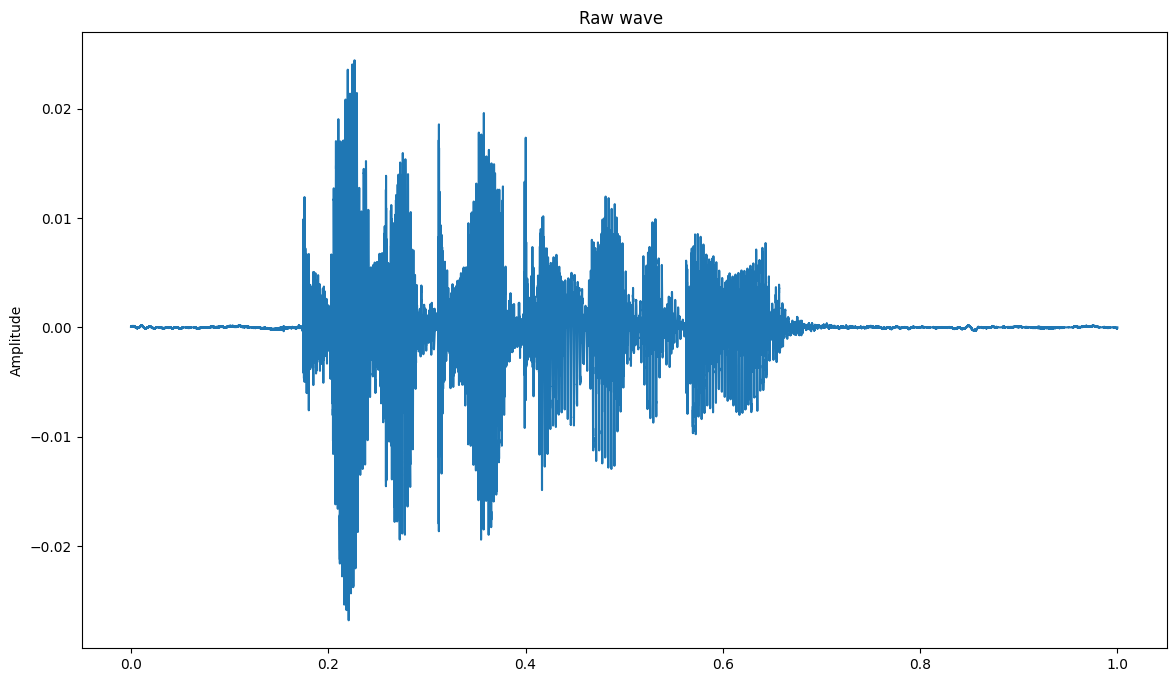

In [41]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

[ 5.9052909e-05  7.8029807e-05  8.9414789e-05 ... -8.4891566e-05
 -6.5962136e-05  0.0000000e+00]


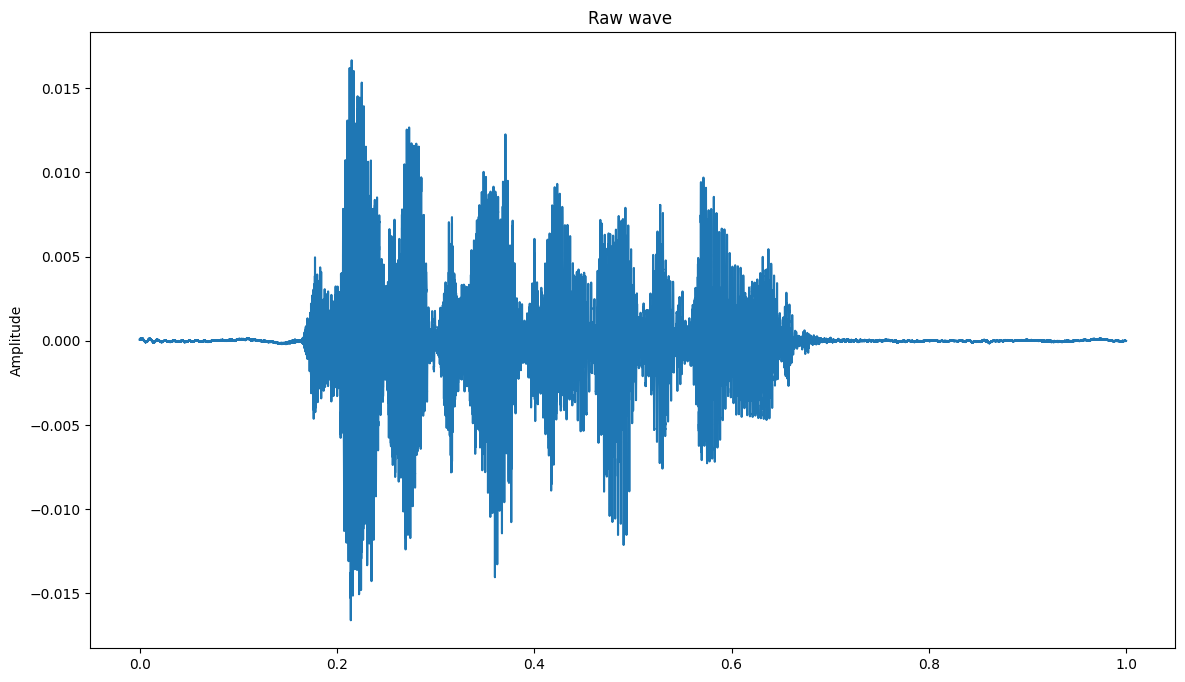

In [42]:
print(X)
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [43]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]
        

100%|██████████| 400/400 [00:47<00:00,  8.44it/s]


In [44]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]
        

100%|██████████| 400/400 [01:41<00:00,  3.93it/s]


In [45]:
len(syn_data1), len(syn_data2) 

(400, 400)

In [46]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [47]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

400

In [48]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-64.917649,-62.425079,-59.388882,-57.477057,-60.604410,-58.583219,-57.500374,-58.249646,-58.684434,-59.239124,...,-59.666608,-62.225707,-60.244652,-58.286444,-57.987866,-57.882104,-57.063623,-56.861460,-60.160036,male_positive
1,-67.077151,-65.263140,-63.951139,-63.273682,-61.306972,-64.340146,-68.528320,-66.996488,-64.683778,-64.488806,...,-64.628659,-63.576288,-63.529290,-62.301780,-64.482818,-66.302713,-64.646104,-63.061422,-65.803869,male_positive
2,-61.537908,-60.165640,-56.357796,-54.989526,-56.798724,-55.205005,-54.312555,-57.202414,-57.990931,-53.848464,...,-52.702249,-53.473306,-54.545499,-55.606410,-54.040449,-54.292604,-55.504852,-57.037103,-56.176042,male_positive
3,-65.242934,-65.167119,-65.136944,-65.264075,-65.203987,-65.220672,-64.917010,-65.259055,-65.251548,-65.224567,...,-62.915531,-61.786395,-63.193880,-63.233373,-59.668901,-58.881696,-63.706058,-64.265797,-64.929419,male_positive
4,-53.089426,-51.094523,-52.569363,-54.939638,-53.767196,-53.569148,-54.638134,-54.651397,-54.326516,-54.682337,...,-54.162784,-55.364735,-54.430464,-53.605627,-55.245957,-55.176842,-54.977136,-53.495930,-54.053592,male_negative


In [49]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

400

In [50]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.038337,-70.038337,-70.038337,-70.038337,-70.038337,-69.863403,-66.806576,-70.038337,-70.038337,-70.038337,...,-70.038337,-70.038337,-70.038337,-70.038337,-70.038337,-70.038337,-70.038337,-70.038337,-70.038337,male_positive
1,-70.695436,-70.695436,-70.695436,-70.695436,-70.695436,-70.695436,-70.695436,-70.695436,-70.695436,-70.695436,...,-70.695436,-70.695436,-70.695436,-70.695436,-70.695436,-70.695436,-70.695436,-70.695436,-70.695436,male_positive
2,-72.421502,-72.421502,-72.421502,-72.421502,-72.421502,-72.421502,-72.421502,-72.421502,-72.421502,-72.166129,...,-72.421502,-72.421502,-72.421502,-72.421502,-72.421502,-72.421502,-72.421502,-72.421502,-72.421502,male_positive
3,-67.165944,-67.165944,-67.165944,-67.165944,-67.165944,-67.165944,-67.165944,-67.165944,-67.165944,-67.165944,...,-63.954259,-64.899854,-65.751037,-64.652738,-62.760771,-63.186534,-66.835077,-67.165944,-67.165944,male_positive
4,-66.265572,-66.265572,-66.265572,-66.265572,-66.265572,-66.235928,-64.972287,-65.198252,-66.265572,-66.265572,...,-66.570075,-66.273127,-65.904143,-66.209741,-66.292210,-66.264069,-66.497035,-66.261054,-66.268268,male_negative


In [51]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-65.434349,-65.635201,-67.558136,-67.558136,...,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,-67.558136,male_positive
1,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,...,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,-70.268776,male_positive
2,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,...,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,-69.694000,male_positive
3,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,-65.243164,...,-63.230820,-62.420143,-64.017830,-64.264740,-60.682083,-59.731674,-64.104630,-65.243164,-65.243164,male_positive
4,-63.524330,-63.524330,-63.524330,-63.524330,-63.524330,-63.524330,-61.551132,-63.393112,-63.524330,-63.524330,...,-63.666557,-63.106506,-63.281620,-63.524330,-63.524330,-63.524330,-62.267845,-61.951962,-63.524330,male_negative


In [52]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [53]:
y_train.value_counts()

male_negative    576
male_positive    384
Name: label, dtype: int64

In [54]:
y_test.value_counts()

male_negative    144
male_positive     96
Name: label, dtype: int64

In [55]:
X_train.isna().sum().sum()

0

In [56]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [57]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [58]:
X_train.shape

(960, 259)

# VIII. Changing dimension for CNN model

In [59]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [60]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [61]:
# Original Model
from tensorflow.keras import optimizers
model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(5))
model.add(Activation('softmax'))

In [62]:
# Plotting Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 259, 256)          1536      
                                                                 
 activation (Activation)     (None, 259, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 259, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 259, 128)          0         
                                                                 
 dropout (Dropout)           (None, 259, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 128)          0         
 )                                                               
                                                        

# IX. Removed the whole training part for avoiding unnecessary long epochs list

## Saving the model

In [63]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

# X. Predicting emotions on the test data

In [64]:
len(data3_df)

80

In [65]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',
                                  duration=input_duration, sr=22050*2, 
                                  offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 80/80 [00:19<00:00,  4.00it/s]


In [66]:
preds = model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

5/5 [==============================] - 1s 42ms/step


In [67]:
preds

array([[0.0719697 , 0.19379716, 0.41920987, 0.11575494, 0.19926834],
       [0.09048558, 0.18807514, 0.4396667 , 0.10610686, 0.17566575],
       [0.08142803, 0.1708423 , 0.4585501 , 0.10457107, 0.18460844],
       [0.08832839, 0.20208168, 0.4217114 , 0.11318141, 0.17469712],
       [0.0798544 , 0.19079036, 0.41440398, 0.12407743, 0.19087368],
       [0.08617087, 0.17084725, 0.42177308, 0.12077104, 0.20043775],
       [0.07759496, 0.19805223, 0.4508913 , 0.09992515, 0.17353639],
       [0.08053821, 0.20160268, 0.41578326, 0.10767896, 0.19439693],
       [0.08117979, 0.16816191, 0.4658321 , 0.10186494, 0.1829611 ],
       [0.07802895, 0.18519178, 0.44090828, 0.11101386, 0.18485712],
       [0.08521184, 0.16259697, 0.45496616, 0.10684993, 0.19037515],
       [0.06553288, 0.17437561, 0.46470118, 0.11062195, 0.18476845],
       [0.07526873, 0.19068381, 0.42375886, 0.11644469, 0.19384392],
       [0.08867832, 0.1705079 , 0.4372864 , 0.10872139, 0.19480608],
       [0.08315929, 0.19870764, 0.

In [68]:
preds1=preds.argmax(axis=1)

In [69]:
preds1

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2])

In [70]:
abc = preds1.astype(int).flatten()

In [71]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [72]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]


#end of code#

,actualvalues
0,male_positive
1,male_positive
2,male_positive
3,male_positive
4,male_positive
5,male_positive
6,male_positive
7,male_positive
8,male_positive
9,male_positive
